In [1]:
from sklearn import neighbors, cluster
from sklearn.metrics import pairwise
from sklearn.manifold import SpectralEmbedding

from scipy.spatial.distance import pdist, squareform
!pip install pygsp
import pygsp
import torch
import numpy as np


def create_graph_from_layered_embedding(embs, frac:float = 0.1, n_clusters:int = 0):
    n_hidden = len(embs)
    layers = [e.shape[0] for e in embs]

    neighs = [neighbors.NearestNeighbors(n_neighbors=int(frac * layers[i] + 1), metric='cosine').fit(embs[i]) for i in range(n_hidden)]
    ids_per_layer = [sum(layers[:i]) + np.arange(layers[i], dtype=int) for i in range(n_hidden)]

    adj_mat = np.zeros((sum(layers), sum(layers)))

    for i in range(n_hidden):
        dist, ids = [x[:, 1:] for x in neighs[i].kneighbors(embs[i], return_distance=True)]
        for v1,v2s in enumerate(ids):
            adj_mat[ids_per_layer[i][v1], ids_per_layer[i][v2s]] = 1 - dist[v1,:]

        if i != n_hidden - 1:
            dist, ids = [x[:, :-1] for x in neighs[i + 1].kneighbors(embs[i], return_distance=True)]
            for v1,v2s in enumerate(ids):
                adj_mat[ids_per_layer[i][v1], ids_per_layer[i + 1][v2s]] = 1 - dist[v1,:]

        if i != 0:
            dist, ids = [x[:, :-1] for x in neighs[i - 1].kneighbors(embs[i], return_distance=True)]
            for v1,v2s in enumerate(ids):
                adj_mat[ids_per_layer[i][v1], ids_per_layer[i - 1][v2s]] = 1 - dist[v1,:]

    adj_mat = (adj_mat + adj_mat.T) / 2

    if n_clusters <= 0:
        return adj_mat

    clusts = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(adj_mat).labels_

    mask = np.zeros_like(adj_mat)
    for i in range(clusts.max() + 1):
        mask[np.ix_(clusts == i, clusts == i)] = 1.0

    return (adj_mat > 1e-5) * mask

In [2]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

import gc
import collections
from functools import partial

import seaborn as sns

import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

%config Completer.use_jedi = False

dev = 'cuda:0'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [3]:
class Net(nn.Module):
    def __init__(self, layers, drop_p=0.2):
        super(Net,self).__init__()
        self.hidden = nn.ModuleList()
        for li,lo in zip(layers, layers[1:]):
            self.hidden.append(nn.Linear(li, lo))
        self.droput = nn.Dropout(drop_p)
        
    def forward(self,x):
        x = x.view(-1, INPUT_SHAPE)
        for i,l in enumerate(self.hidden):
            x = l(x)
            if i < len(self.hidden) - 1:
                x = self.droput(F.relu(x))
        return x

def eval_nn(nn, testloader):
    correct = 0
    loss_sublist = []
    for x,y in testloader:
        x,y = x.to(dev), y.to(dev)
        nn.eval()
        z = nn(x)
        _, yh = torch.max(z.data, 1)
        correct += (yh == y).sum().item()
        loss_sublist.append(crit(z, y).data.item())
    acc = correct / n_test
    return acc, round(np.mean(loss_sublist), 4)

def run_nn_train(nn, x, y, optimizer, crit):
    x,y = x.to(dev), y.to(dev)
    nn.train()
    optimizer.zero_grad()
    z = nn(x)
    return crit(z, y)

def clean_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainset_raw = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100000, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100000, shuffle=False, num_workers=2)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10

## Simple MLP

In [5]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [6]:
%%time

N_EPOCHS = 20
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
graph = None

for e in range(N_EPOCHS):
    # Train
    loss_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())

        loss.backward()
        optimizer.step()

    # Test
    acc, test_loss = eval_nn(mlp, testloader)
    del x,y,loss
    clean_mem()

    test_loss_list.append(test_loss)
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss_list[-1]}')

0. Accuracy: 0.1277, CE: 2.2878
1. Accuracy: 0.2037, CE: 2.2651
2. Accuracy: 0.2836, CE: 2.2406
3. Accuracy: 0.3214, CE: 2.2104
4. Accuracy: 0.3285, CE: 2.1757
5. Accuracy: 0.3231, CE: 2.1372
6. Accuracy: 0.3095, CE: 2.0952
7. Accuracy: 0.2976, CE: 2.0501
8. Accuracy: 0.2937, CE: 2.0026
9. Accuracy: 0.3003, CE: 1.9546
10. Accuracy: 0.326, CE: 1.9079
11. Accuracy: 0.354, CE: 1.8635
12. Accuracy: 0.3727, CE: 1.8226
13. Accuracy: 0.3874, CE: 1.7847
14. Accuracy: 0.4012, CE: 1.7499
15. Accuracy: 0.4106, CE: 1.7176
16. Accuracy: 0.4221, CE: 1.6868
17. Accuracy: 0.4362, CE: 1.6561
18. Accuracy: 0.4567, CE: 1.6262
19. Accuracy: 0.4787, CE: 1.5966
CPU times: user 4.06 s, sys: 3.62 s, total: 7.69 s
Wall time: 3min 2s


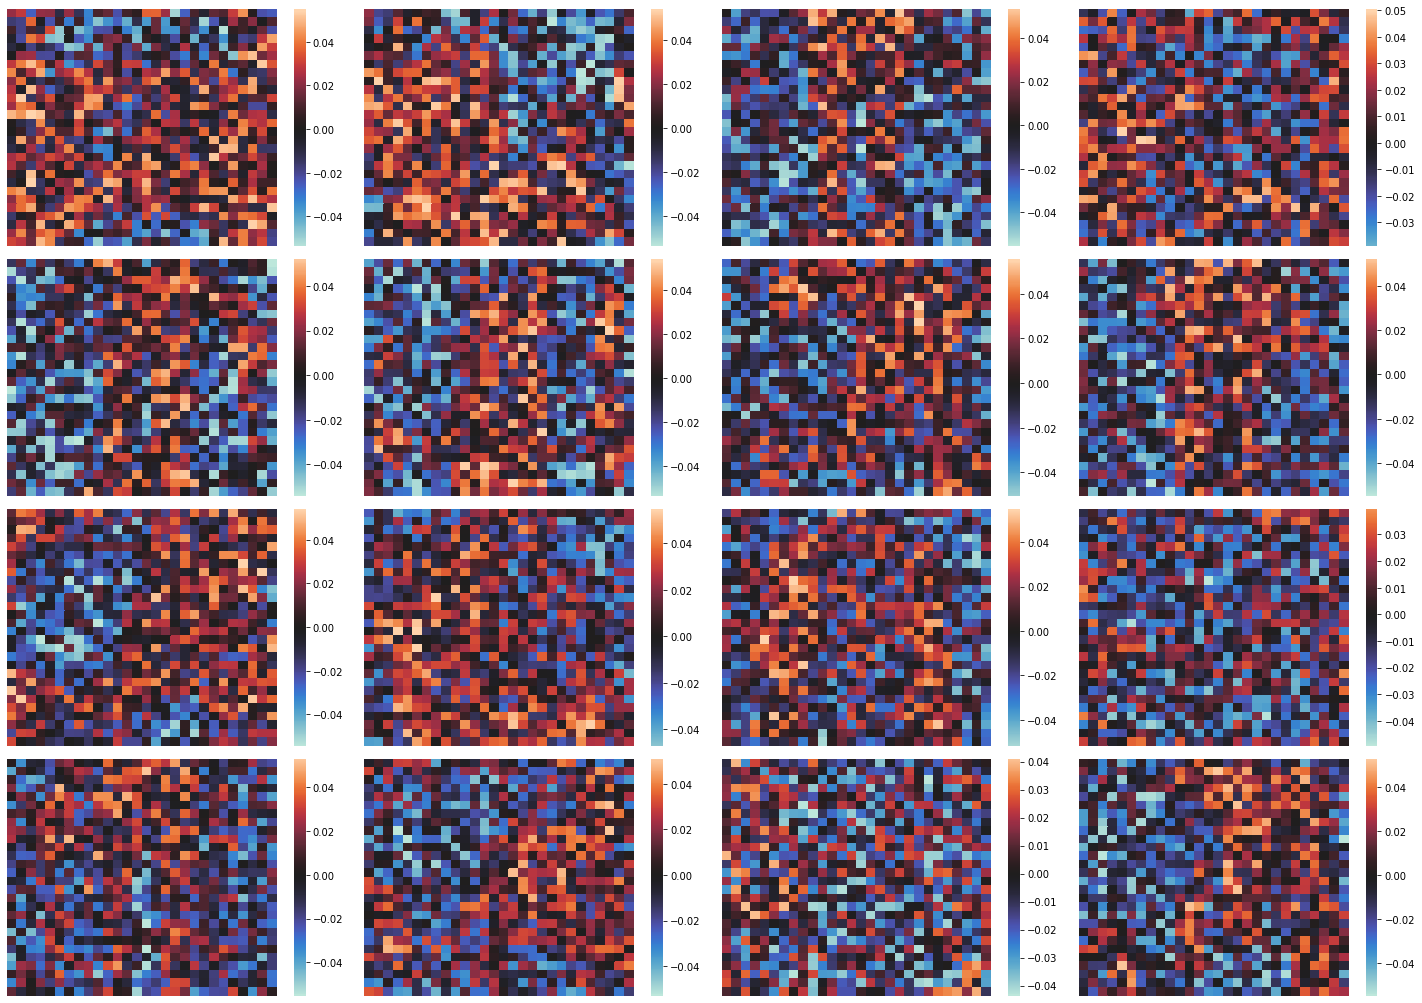

In [7]:
l1 = dict(mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()

## Graph MLP

In [8]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
n_hidden = len(layers) - 2
ids_per_layer = [sum(layers[1:(i+1)]) + np.arange(layers[i+1], dtype=int) for i in range(n_hidden)]

graph_mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(graph_mlp.parameters(), lr=0.001)
for name, m in graph_mlp.named_modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(lambda name, mod, inp, out: activations[name].append(out.cpu()), name))

In [12]:
%%time

N_EPOCHS = 20
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
lap = None

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(graph_mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())

        embs = [torch.vstack(activations[f'hidden.{i}']).T.detach().numpy() for i in range(n_hidden)]
        adj_mat = torch.from_numpy(create_graph_from_layered_embedding(embs, frac=0.3))

        degreessqrt = adj_mat.sum(0, keepdims=True).pow(-1./2.)
        adjnorm = adj_mat*degreessqrt*degreessqrt.T
        lap = torch.eye(adjnorm.shape[0]) - adjnorm
        act = torch.hstack([activations[f'hidden.{li}'][-1] for li in range(n_hidden)])
        loss += (act.mm(lap) * act).sum() / act.shape[1] * 0.005

        loss.backward()
        optimizer.step()

    # Test
    acc, test_loss = eval_nn(graph_mlp, testloader)
    del x,y,loss
    clean_mem()
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss}')

RuntimeError: ignored

In [ ]:
%debug

In [ ]:
embs = [torch.vstack(activations[f'hidden.{i}']).T.detach().numpy() for i in range(n_hidden)]
adj_mat = create_graph_from_layered_embedding(embs, frac=0.3)

spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

In [ ]:
for i,ids in enumerate(ids_per_layer):
    plt.scatter(spec_emb[ids,0], spec_emb[ids,1], s=5, label=i)
plt.legend();

In [ ]:
l1 = dict(graph_mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()